In [1]:
import math
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from tokenizers import (
    pre_tokenizers,
    decoders,
    models,
    trainers,
    Tokenizer,
)
from tokenizers.pre_tokenizers import Split, Punctuation, Digits

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

DEVICE = torch.device('cuda') # 'mps' for ARM macbooks, 'cuda' for colab, 'cpu' otherwise

## Data

In [2]:
!wget https://github.com/holmrenser/deep_learning/raw/main/data/openwebtext_subset.txt.tgz
!tar xvzf openwebtext_subset.txt.tgz
!wc -l openwebtext_subset.txt

--2024-04-03 12:54:18--  https://github.com/holmrenser/deep_learning/raw/main/data/openwebtext_subset.txt.tgz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/holmrenser/deep_learning/main/data/openwebtext_subset.txt.tgz [following]
--2024-04-03 12:54:18--  https://raw.githubusercontent.com/holmrenser/deep_learning/main/data/openwebtext_subset.txt.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80920665 (77M) [application/octet-stream]
Saving to: ‘openwebtext_subset.txt.tgz.1’

openwebtext_subset. 100%[===================>]  77.17M   328MB/s    in 0.2s    

2024-04-03 12:54:18 (328 MB/s) - ‘o

In [3]:
!head -n 50000 openwebtext_subset.txt > sample.txt

In [4]:
%%time
class TextDataset:
    def __init__(self, tokens: list[int], tokenizer, context_size: int=256):
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {context_size=})'

    @classmethod
    def from_textfile(cls, filename: str, tokenizer, context_size: int=256) -> 'TextDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        with open(filename, 'r') as fh:
            data = fh.read()
            tokens = tokenizer.encode(data).ids
            return cls(tokens, tokenizer, context_size=context_size)

    def train_test_split(self, train_percentage: float=0.8) -> tuple['TextDataset','TextDataset']:
        n_train_chars = int(train_percentage * len(self.tokens))

        train_tokens = self.tokens[:n_train_chars]
        train_dataset = TextDataset(train_tokens, self.tokenizer, self.context_size)

        test_tokens = self.tokens[n_train_chars:]
        test_dataset = TextDataset(test_tokens, self.tokenizer, self.context_size)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.tokens) - self.context_size

    def __getitem__(self, pos: int) -> torch.tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        tokens = self.tokens[pos:pos + self.context_size + 1]
        # encode every character to an integer
        # tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

# Specify a BPE tokenizer using Huggingface's tokenizers
tokenizer = Tokenizer(models.BPE(byte_fallback=True))
#tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
#    Split(pattern='\s', behavior='isolated'),
#    Punctuation(),
#    Digits(individual_digits=True)
#  ])
trainer = trainers.BpeTrainer(
    vocab_size=1024
)
tokenizer.decoder = decoders.ByteLevel()

# Train on shakespeare
tokenizer.train(["sample.txt"], trainer=trainer)

dataset = TextDataset.from_textfile('./sample.txt', tokenizer=tokenizer)
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

CPU times: user 45.9 s, sys: 1.08 s, total: 47 s
Wall time: 31 s


(1723987, 430805)

In [5]:
class MLP(nn.Module):
    """Simple multi-layer perceptron with two linear layers and a relu non-linearity in between"""
    def __init__(self, embedding_dim: int, bias: bool, dropout: float):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4*embedding_dim, bias=bias),
            nn.ReLU(),
            nn.Linear(in_features=4*embedding_dim, out_features=embedding_dim, bias=bias),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

class MultiHeadDotProductAttention(nn.Module):
    """Multi Head Dot Product attention"""
    def __init__(self, embedding_dim: int, n_heads: int, bias: bool, dropout: float, causal: bool):
        super().__init__()
        if embedding_dim % n_heads != 0:
            raise Exception('n_heads must be dividable by n_embed')

        self.n_heads = n_heads
        self.causal = causal

        # attention input projections
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)

        # output projection
        self.out_project = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)

        #dropouts
        self.attention_dropout = nn.Dropout(dropout)
        self.projection_dropout = nn.Dropout(dropout)
        self.dropout = dropout

    def forward(self, x: torch.tensor) -> torch.tensor:
        # B, L, N
        # N = n_heads x head_size
        batch_dim, input_length, embedding_dim = x.size()

        # calculate input projections and divide over heads
        # 'view' and 'transpose' reorder in subtly different ways and we need both
        # (B, L, n_heads, head_dim) -> (B, n_heads, L, head_dim)
        q = self.w_q(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        k = self.w_k(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        v = self.w_v(x).view(batch_dim, input_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)

        pred = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        # calculate attention
        # (B, n_heads, L, head_size) x (B, n_heads, head_size, L) -> (B, n_heads, L, L)
        #attention = (q @ v.transpose(-2, -1)) / math.sqrt(embedding_dim)
        #if self.causal:
        #    mask = torch.triu(torch.ones(input_length, input_length, dtype=torch.bool, device=q.device), diagonal=1)
        #    attention = attention.masked_fill(mask, -torch.inf)
        #attention = F.softmax(attention, dim=-1)
        #attention = self.attention_dropout(attention)

        # weight outputs with calculated attention
        # (B, n_heads, L, L) x (B, n_heads, L, head_dim) -> (B, n_heads, L, head_dim)
        #pred = attention @ v

        # reshape multiple heads back into contiguous representation
        pred = pred.transpose(1, 2).contiguous().view(batch_dim, input_length, embedding_dim)

        # return linear projection
        return self.projection_dropout(self.out_project(pred))

class TransformerBlock(nn.Module):
    """Transformer block that combines attention and MLP, both with pre-layernorm and residual connections"""
    def __init__(self, embedding_dim: int, n_heads:int, bias:bool, dropout:float, causal: bool):
        super().__init__()
        self.attention = nn.Sequential(
            MultiHeadDotProductAttention(
                embedding_dim=embedding_dim,
                n_heads=n_heads,
                bias=bias,
                dropout=dropout,
                causal=causal
            ),
            nn.LayerNorm(embedding_dim)
        )
        self.mlp = nn.Sequential(
            MLP(embedding_dim=embedding_dim, bias=bias, dropout=dropout),
            nn.LayerNorm(embedding_dim)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate attention and communication between channels, both with residual connections"""
        # Communicate between positions (i.e. attention)
        attn = self.attention(x) + x
        # Communicate between embedding dimensions
        res = self.mlp(attn) + attn
        return res

class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to already embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Add positional embeddings based on input dimensions, use residual connection"""
        pos = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

class GPT(nn.Module):
    def __init__(
        self,
        context_size: int=None,
        vocab_size: int=None,
        n_layers: int=6,
        n_heads: int=8,
        embedding_dim: int=384,
        dropout: float=0.1,
        bias: bool=False
    ):
        super().__init__()
        self.context_size = context_size
        self.vocab_size = vocab_size

        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
            AdditivePositionalEmbedding(context_size, embedding_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[TransformerBlock(embedding_dim=embedding_dim, n_heads=n_heads, bias=bias, dropout=dropout, causal=True) for _ in range(n_layers)]),
            nn.LayerNorm(embedding_dim, bias=bias),
            nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False)
        )

        # weight tying of input embedding and output projection (https://paperswithcode.com/method/weight-tying)
        self.transformer[0].weight = self.transformer[-1].weight

        # init all weights
        self.apply(self._init_weights)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None) -> torch.tensor:
        logits = self.transformer(idx)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        accuracy = None if targets is None else (logits.argmax(dim=-1) == targets).sum() / targets.numel()
        return logits,loss,accuracy

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate(self, prompt:str='\n', sample_length: int=256) -> list[int]:
        """Generate sample tokens"""
        device = next(self.parameters()).device
        prompt_tokens = dataset.tokenizer.encode(prompt).ids
        idx = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

        for _ in trange(sample_length, desc='Sampling'):
            logits,_,_ = self(idx[-self.context_size:][None])
            logits = logits[0,-1,:]

            probs = F.softmax(logits, dim=0)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next])

        return idx.tolist()


model = GPT(context_size=dataset.context_size, vocab_size=dataset.vocab_size)
sample = model.generate('I am')
print([dataset.tokenizer.decode([s]) for s in sample])

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

['I ', 'am', 'want', '真', 'am', '+', 'some ', 'П', ' the', 'us ', 'ance ', 'kn', 'L', 'ṇ', ';', 'our', 'ese ', 'from ', 'mon', '́', '�', 'ud', 'ound', 'ず', '釗', 'ill ', '�', 'an ', '\ue80f', '�', 'reg', 'θ', '\ue001', 'р', 'ϵ', '・', 'ec', '\uf0a5', 'in ', 'eg', '<', 'one ', '=', 'wr', '€', 'ew ', '\ue000', 'duc', '̄', 'ec', 'ess', 'Н', 'e and ', 'aus', '❤', 'd ', 'ser', 'ia ', 'ers', '-', 'e ', 'her ', 'н', 'av', 'om', ' tr', 'said ', 'no ', 'ite ', 'e, ', 'or', '�', 'igh', 'λ', 'ach ', 'oug', 'will ', 'an ', 'us', 'includ', 'bel', 'only ', 'Л', '3', '�', 'and the ', 'ы', 'op', 'ies', 'j', 'on the ', '1 ', 'ow ', 'arg', 'ans ', '20', 'coun', 'ly', 'с', '~', 'part', '固', 'ἥ', ', ', 'ay', '"', 'ι', '@', '降', 'au', 'as', 'ack', 'い', 'Ch', '�', 'o the ', 'a ', 'ser', 'ks ', 'not ', 'n ', 'ne', 'ev', 'チ', 'th ', '■', '�', 'al', ':\n', 'м', '―', 'mar', 'from ', '\uf064', 'gre', 'ri', '\x99', 'Z', 'able ', '真', '‘', 'ね', 'rem', 'ip', 'o', 'as ', 'e. ', 'ous ', '&', '$', 'い', 'enc', 'ach ', 'r

## Training

  0%|          | 0/10000 [00:00<?, ?it/s]

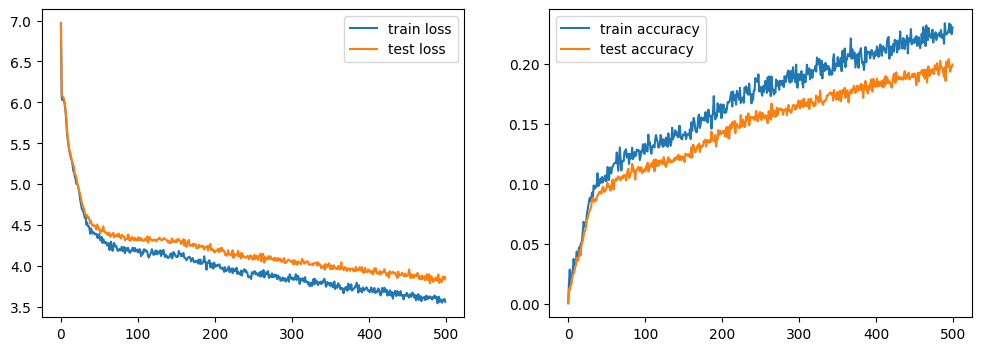

In [6]:
dataset = TextDataset.from_textfile('./sample.txt', tokenizer=tokenizer, context_size=256)

model = GPT(
    context_size=dataset.context_size,
    vocab_size=dataset.vocab_size,
    embedding_dim=256,
    n_layers=6,
    dropout=0.2
)
model.to(DEVICE)
model.train()

train_steps = 10000
batch_size = 128

train_dataset, test_dataset = dataset.train_test_split()

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True),
    batch_size=batch_size,
)
test_dataloader = iter(test_dataloader)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
model.train()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for i, (train_x, train_y) in enumerate(tqdm(train_dataloader)):
    # forward the model
    _,train_loss,train_accuracy = model(train_x.to(DEVICE), train_y.to(DEVICE))

    # save losses on train and test every 20 iterations
    if i % 20 == 0:
        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_x, test_y = next(test_dataloader)
        _,test_loss,test_accuracy = model(test_x.to(DEVICE), test_y.to(DEVICE))
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy.item())

    # backprop and update the parameters
    model.zero_grad(set_to_none=True)
    train_loss.backward()

    # 'trick' to prevent gradients from exploding
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

fig,[ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(train_losses, label='train loss')
ax1.plot(test_losses, label='test loss')
ax1.legend()
ax2.plot(train_accuracies, label='train accuracy')
ax2.plot(test_accuracies, label='test accuracy')
ax2.legend()

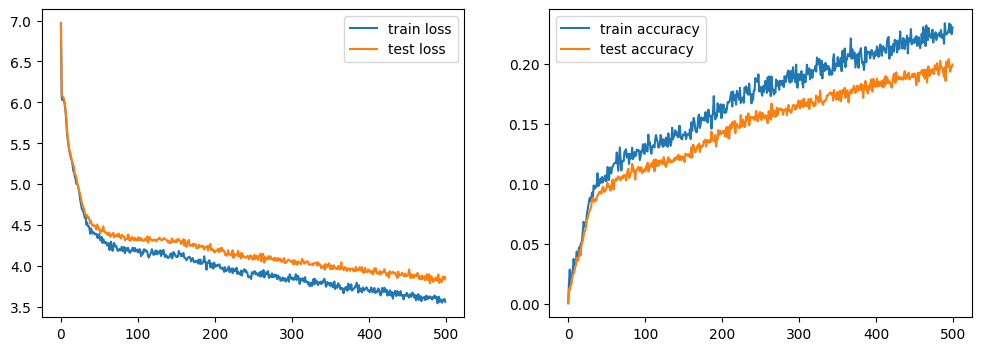

In [12]:
fig,[ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(train_losses, label='train loss')
ax1.plot(test_losses, label='test loss')
ax1.legend()
ax2.plot(train_accuracies, label='train accuracy')
ax2.plot(test_accuracies, label='test accuracy')
ax2.legend()

In [11]:
import types
def generate(
    self,
    prompt:str='\n',
    sample_length: int=256,
    deterministic: bool=False,
    top_k: int=4,
    temperature: float=0.1
) -> list[int]:
    """Generate sample tokens"""
    device = next(self.parameters()).device
    prompt_tokens = dataset.tokenizer.encode(prompt).ids
    idx = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

    for _ in trange(sample_length, desc='Sampling'):
        logits,_,_ = self(idx[-self.context_size:][None])
        logits = logits[0,-1,:]

        if deterministic:
            idx_next = logits.argmax()[None]
        else:
            if top_k:
                logits[logits.argsort()[:-top_k]] = -torch.inf
            if temperature:
                logits = logits / temperature
            probs = F.softmax(logits, dim=0)
            idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, idx_next])

    return idx.tolist()
setattr(model, "generate", types.MethodType(generate, model))

model.eval()
sample = model.generate(prompt='Today is ', top_k=5, temperature=1.)
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

Today is not general two family of the system.



There is a powerful moderial futures of the center is capital of color may be digital document and camera, and many colonizations (the source ce), as focus or document, or curred of a photosenomen depth of colors (sized as possible of the lens and factor sized on factor, as possible of the same of the object between (which may be digital as an exists (as many of the size camera is not as a difficult of the cameras movements in the sized digital object of the limit may be used to a paper demand terms (or color_including data) – data, in a digital light and may be us
